## Comparison of Lasso Factorial Selection with Forward Selection

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
from factorial_model import FactorialModel
from forward_selection import ForwardSelection

### Initialize factorial model

In [43]:
# CHOOSE K AND DEGREE
fm = FactorialModel(
    n=1000,
    k=4,
    degree=4,
    sigma=0.1,
    sparsity=0.5,
    contrast_coding=True,
    beta_seed=0,
)

In [44]:
# CHOOSE ONE BETA SAMPLING METHOD
# fm.sample_normal_beta()
fm.sample_skewed_beta(min_active_degree=2)
true_beta = fm.beta
beta_mask = fm.pf.fit_transform(fm.pf.powers_)
true_expected_outcomes = beta_mask @ true_beta

In [45]:
# Method to evaluate Lasso model
def evaluate_lasso():
    fm.sample_and_split_data(seed=None)
    fm.fit_lasso()
    fm.predict()
    fm.compute_mse()
    fm.compute_r2()

In [46]:
# Method to evaluate forward selection
def evaluate_forward_selection(T_test, y_test):
    fs.forward_selection()
    fs.predict(T_test)
    fs.compute_mse(y_test)
    fs.compute_r2()

In [47]:
# Evaluate two models for NUM_TRIALS
NUM_TRIALS = 30
lasso_mses = []
fs_mses = []
lasso_r2s = []
fs_r2s = []
lasso_betas = []
fs_betas = []
lasso_expected_outcomes = []
fs_expected_outcomes = []

for i in range(NUM_TRIALS):
    evaluate_lasso()
    lasso_mses.append(fm.mse)
    lasso_r2s.append(fm.r2)
    lasso_betas.append(fm.beta_hat)
    lasso_expected_outcomes.append(fm.expected_outcomes)

    fs = ForwardSelection(fm.T_train, fm.y_train, fm.k, strong_heredity=False)
    evaluate_forward_selection(fm.T_test, fm.y_test)
    fs_mses.append(fs.mse)
    fs_r2s.append(fs.r2)
    fs_betas.append(fs.results.params)
    beta_mask = fm.pf.fit_transform(fm.pf.powers_)
    fs_expected_outcome = beta_mask @ fs.results.params
    fs_expected_outcomes.append(fs_expected_outcome)

In [48]:
# MSE comparison
avg_lasso_mse = np.mean(np.array(lasso_mses))
avg_fs_mses = np.mean(np.array(fs_mses))
std_lasso_mse = np.std(np.array(lasso_mses))
std_fs_mses = np.std(np.array(fs_mses))
print(f"Lasso MSE: {avg_lasso_mse} +/- {std_lasso_mse}")
print(f"Forward Selection MSE: {avg_fs_mses} +/- {std_fs_mses}")

Lasso MSE: 0.00978160145746147 +/- 0.0007738802220825707
Forward Selection MSE: 0.9460632727235715 +/- 0.19210268537641084


In [49]:
# R2 comparison
avg_lasso_r2 = np.mean(np.array(lasso_r2s))
avg_fs_r2 = np.mean(np.array(fs_r2s))
std_lasso_r2 = np.std(np.array(lasso_r2s))
std_fs_r2 = np.std(np.array(fs_r2s))
print(f"Lasso R2: {avg_lasso_r2} +/- {std_lasso_r2}")
print(f"Forward Selection R2: {avg_fs_r2} +/- {std_fs_r2}")

Lasso R2: 0.9902021358400845 +/- 0.0012218331984999577
Forward Selection R2: 0.07157909647834254 +/- 0.18172121242870118


In [50]:
# Beta comparison
lasso_beta_ztest_pvals = [ztest(lasso_beta, true_beta)[1] for lasso_beta in lasso_betas]
fs_beta_ztest_pvals = [ztest(fs_beta, true_beta)[1] for fs_beta in fs_betas]
avg_lasso_beta_ztest_pval = np.mean(np.array(lasso_beta_ztest_pvals))
avg_fs_beta_ztest_pval = np.mean(np.array(fs_beta_ztest_pvals))
print(f"Lasso beta Z-test: {avg_lasso_beta_ztest_pval}")
print(f"Forward Selection beta Z-test: {avg_fs_beta_ztest_pval}")

Lasso beta Z-test: 0.9811295188324096
Forward Selection beta Z-test: 0.28497367730927675


In [51]:
# Expected outcomes comparison
lasso_outcomes_ztest_pvals = [ztest(lasso_outcome, true_expected_outcomes)[1] for lasso_outcome in lasso_expected_outcomes]
fs_outcomes_ztest_pvals = [ztest(fs_outcome, true_expected_outcomes)[1] for fs_outcome in fs_expected_outcomes]
avg_lasso_outcomes_ztest_pval = np.mean(np.array(lasso_outcomes_ztest_pvals))
avg_fs_outcomes_ztest_pval = np.mean(np.array(fs_outcomes_ztest_pvals))
print(f"Lasso expected outcomes Z-test: {avg_lasso_outcomes_ztest_pval}")
print(f"Forward Selection expected outcomes Z-test: {avg_fs_outcomes_ztest_pval}")

Lasso expected outcomes Z-test: 0.8356391081068464
Forward Selection expected outcomes Z-test: 0.3459119109762869


### Validate theoretical lower bound on number of observations

- General bound (HDP 10.3.5): $n \geq s \log 2^k$
- Looser bound (HDP 10.3.8): $n \geq s \log (e2^k/s)$
- Noisy bound (HDP 10.6.1-2): $\lVert \hat{x} - x \rVert_2 \leq C \sigma \sqrt{\frac{s \log 2^k}{n}}$

where $n$ = number of observations, $s$ = number of nonzero coefficients (sparse_count), and $k$ = number of treatments, and $\sigma = \lVert w \rVert_2 / \sqrt{n}$.  Thus we have $n \geq \sigma^2 \cdot s \log 2^k$

In [52]:
num_treatments = 8
num_coeffs = 2 ** num_treatments
percent_sparsity = 0.5
sparse_count = (1 - percent_sparsity) * num_coeffs
general_bound = sparse_count * np.log(num_coeffs)
# looser_bound = sparse_count * np.log(np.exp(1) * num_coeffs / sparse_count)

In [53]:
# Compute noisy bound
fm = FactorialModel(
    n=int(general_bound),
    k=num_treatments,
    degree=num_treatments,
    sigma=0.1,
    sparsity=percent_sparsity,
    contrast_coding=True,
    beta_seed=0,
)

# CHOOSE ONE BETA SAMPLING METHOD
fm.sample_normal_beta()
# fm.sample_skewed_beta(min_active_degree=3)
fm.sample_and_split_data(seed=0)

w_norm = np.linalg.norm(fm.eps)
sigma_sq = w_norm ** 2 / fm.n
noisy_bound = sigma_sq * general_bound

In [54]:
print(f'w_norm: {w_norm}, sigma_sq: {sigma_sq}, general_bound: {general_bound}, noisy_bound: {noisy_bound}')

w_norm: 2.6772822686114206, sigma_sq: 0.010109788922173646, general_bound: 709.782712893384, noisy_bound: 7.175753407959891


In [55]:
num_observations = np.arange(20, 2001, 20)
mse_over_num_obs = []

for n in num_observations:
    fm = FactorialModel(
        n=n,
        k=num_treatments,
        degree=num_treatments,
        sigma=0.1,
        sparsity=percent_sparsity,
        contrast_coding=True,
        beta_seed=0,
    )

    # CHOOSE ONE BETA SAMPLING METHOD
    # fm.sample_normal_beta()
    fm.sample_skewed_beta(min_active_degree=3)
    fm.sample_and_split_data(seed=0)
    fm.fit_lasso()
    fm.predict()
    fm.compute_mse()
    mse_over_num_obs.append(fm.mse)

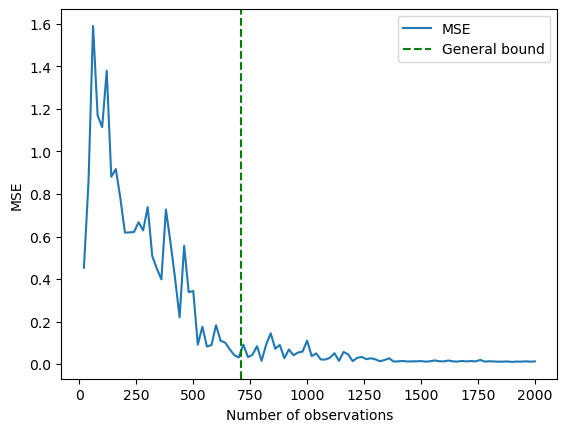

In [56]:
# Plot the results
plt.plot(num_observations, mse_over_num_obs, label="MSE")
plt.axvline(general_bound, color="green", linestyle="--", label="General bound")
# plt.axvline(noisy_bound, color="red", linestyle="--", label="Noisy bound")
plt.xlabel("Number of observations")
plt.ylabel("MSE")
plt.legend()
plt.show()